# Hito 2: FL Inter-empresa

Se entrena un único modelo de manera federada entre las dos empresas. De esta forma, se mantendrá la privacidad de los datos de cada empresa PERO no internamente dentro de las empresas. Se medirá el rendimiento del modelo respecto a los baselines de empresas y centralizado.

El cuaderno es similar a Hito1-IntraEmpresa pero con las modificaciones necesarias para que cada cliente (dos en total) tiene los datos completos de una de las empresas.

# Configuración del escenario mediante Flower

Se hará uso del modulo 'simulation' (version 0.18.0 de la libería) que elimina las restricciones de escalabilidad que se tenían respecto a versiones anteriores

Es necesario instalar Flower con el extra de 'simulation'

In [1]:
# !pip install -U flwr["simulation"]

In [2]:
import os
import math

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adadelta

from typing import Dict

from flwr.common.logger import log
from logging import INFO
from csv import writer

import matplotlib.pyplot as plt

In [3]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, x_train, y_train, x_val, y_val) -> None:
        self.cid = cid
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        
        self.model.fit(self.x_train, self.y_train,
                       epochs=int(config["epochs"]),
                       batch_size=32,
                       verbose=0)
        
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        
        return loss, len(self.x_val), {"accuracy": acc, "client": self.cid}

In [4]:
''' FUNCION PARA CARGAR LOS DATOS DE UN CLIENTE EN PARTICULAR '''
def prepare_model_data(client_file):
    df = pd.read_csv(client_file)
    
    train, test = train_test_split(df, test_size=0.30, random_state=42)
    
    X_train = train[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    X_test = test[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    y_train = train['y_class']
    y_test = test['y_class']
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

''' FUNCION PARA CARGAR LOS DATOS DE UNA EMPRESA '''
def get_data_empresa(empresa):
    base_path = "./data/horizontal_v2"
    # Cargar y procesar datos de todos sus clientes
    clientes = os.listdir(f"{base_path}/{empresa}/")
    
    X_train, X_test, y_train, y_test = prepare_model_data(f'{base_path}/{empresa}/{clientes[0]}')
    
    for file in clientes[1:]:
        path = f'{base_path}/{empresa}/{file}'
        X_train_act, X_test_act, y_train_act, y_test_act = prepare_model_data(path)

        X_train = np.vstack((X_train, X_train_act))
        X_test = np.vstack((X_test, X_test_act))
        y_train = np.concatenate((y_train, y_train_act))
        y_test = np.concatenate((y_test, y_test_act))
        
    return X_train, X_test, y_train, y_test

In [5]:
def client_fn(cid: str) -> fl.client.Client:
    
    # Model best hyperparameters (Ver notebook Hito0-Optimizacion-Baseline)
    neurons = 36
    activation = "relu"
    learning_rate = 0.180165
    optimizer = Adadelta(learning_rate=learning_rate)
    
    input_shape = (7,)
    
    # Create model
    model = Sequential()
    
    model.add(Dense(neurons, input_shape=input_shape, activation=activation))
    
    model.add(BatchNormalization())
        
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Load data partition    
    x_train_cid, x_val_cid, y_train_cid, y_val_cid = get_data_empresa(cid)

    # Create and return client
    return FlowerClient(cid, model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

In [10]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated_weights = super().aggregate_fit(rnd, results, failures)
        
#         if aggregated_weights is not None and rnd==30:
#             # Save aggregated_weights
#             print(f"Saving round {rnd} aggregated_weights...")
#             np.savez(f"round-{rnd}-weights.npz", aggregated_weights)
            
        return aggregated_weights

    def aggregate_evaluate(self, rnd, results, failures):
        super_result = super().aggregate_evaluate(rnd, results, failures)
        
        log(
            INFO,
            f"round-{rnd}-EVALUATION"
        )
        
        accuracy = []
        data = {}
        for r in results:
            acc = r[1].metrics["accuracy"]
            client = r[1].metrics["client"]
            data[client] = acc
            accuracy.append(acc)
        
        df = pd.DataFrame(data, index=[0], columns=sorted(data.keys()))
        df.to_csv(f"./results/hito2.csv", mode='a', index=False, header=False)
        
        log(
            INFO,
            sorted(data.items())
        )
        
        np.array(accuracy)
        log(
            INFO,
            f"Aggregated accuracy: {np.mean(accuracy)} +- {np.std(accuracy)}"
        )
        
        return super_result

In [14]:
# Ahora los clientes son las dos empresas
CLIENTS_IDS = ["empresa_1", "empresa_2", "empresa_3"]

 # Se inicializa el fichero de resultados
header = CLIENTS_IDS

with open(f"./results/hito2.csv", 'w', ) as f:
    csv_writer = writer(f)
    csv_writer.writerow(header)

# Configuracion de parametros para el entrenamiento desde el servidor
def fit_config(rnd: int) -> Dict[str, str]:
    config = {
        "round": str(rnd),
        "epochs": str(1) # if rnd < 2 else str(5)
    }
    return config

# Start Flower simulation
    # min_fit_clients y min_eval_clients se ponen al maximo de clientes disponibles ya que estamos en un escenario controlado
fl.simulation.start_simulation(
    client_fn=client_fn,
    clients_ids=CLIENTS_IDS,
    client_resources={"num_cpus": 6},
    num_rounds=300,
    strategy=SaveModelStrategy(
        min_available_clients = len(CLIENTS_IDS),
        min_fit_clients = len(CLIENTS_IDS),
        min_eval_clients = len(CLIENTS_IDS),
        on_fit_config_fn = fit_config,
        on_evaluate_config_fn = fit_config
    )
)

INFO flower 2022-04-12 14:49:08,946 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 5707794432.0, 'node:127.0.0.1': 1.0, 'memory': 11415588864.0, 'GPU': 1.0}
INFO flower 2022-04-12 14:49:08,947 | app.py:153 | Starting Flower simulation running: {'num_rounds': 300}
INFO flower 2022-04-12 14:49:08,947 | server.py:128 | Initializing global parameters
INFO flower 2022-04-12 14:49:08,947 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-12 14:49:12,408 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-12 14:49:12,409 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-12 14:49:12,410 | server.py:143 | FL starting
DEBUG flower 2022-04-12 14:49:12,410 | server.py:265 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-04-12 14:49:16,483 | server.py:277 | fit_round received 3 results and 0 failures
DEBUG flower 2022-04-12 14:49:16,490 | server.py:2

History (loss, distributed):
	round 1: 0.628042093389049
	round 2: 0.5824589633215564
	round 3: 0.5734169602455637
	round 4: 0.5706107172825299
	round 5: 0.5703616847386052
	round 6: 0.568625839066891
	round 7: 0.5694752639365951
	round 8: 0.5644311552889086
	round 9: 0.5648142537646924
	round 10: 0.5644553302693023
	round 11: 0.5636468290236598
	round 12: 0.5622367312938118
	round 13: 0.5637894517140231
	round 14: 0.5638572524281837
	round 15: 0.5618588977992658
	round 16: 0.5621362068400002
	round 17: 0.5601137282310152
	round 18: 0.5609230895905518
	round 19: 0.5595673862626778
	round 20: 0.5589757474563651
	round 21: 0.5605369038361971
	round 22: 0.5603661648647095
	round 23: 0.5593743802286064
	round 24: 0.5593501414439633
	round 25: 0.5603081460860132
	round 26: 0.5631711045709545
	round 27: 0.5589696838682632
	round 28: 0.5605679382169485
	round 29: 0.560499470145105
	round 30: 0.5595345328019065
	round 31: 0.5611939545610569
	round 32: 0.559200380641021
	round 33: 0.55840944577

# Visualización de los resultados

Se mostrarán las métricas obtenidas durante el proceso de entrenamiento federado junto con visualizaciones de la evolucion

Acc máximo: 0.7134524782498678


<AxesSubplot:>

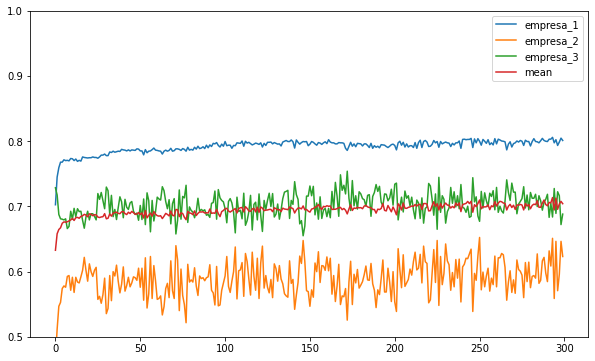

In [17]:
df = pd.read_csv('./results/hito2.csv')
df["mean"] = df.mean(numeric_only=True, axis=1)

print(f'Acc máximo: {df["mean"].max()}')

f = plt.figure(figsize=(10,6))
ax = f.add_subplot()

df.plot(ax=ax, ylim=(0.5,1))

In [16]:
# Acc máximo: 0.7457990944385529